# Adversarial AI (FGSM, PGD, C&W, DeepFool, Few Pixel, Patch)

**Author:** Lennox Anderson

**Sources:** Meyers, C., Löfstedt, T., & Elmroth, E. (2023). Safety-critical computer vision: An empirical survey of adversarial evasion attacks and defenses on computer vision systems. Artificial Intelligence Review, 56(S217–S251). https://doi.org/10.1007/s10462-023-10521-4
***

**Dependencies**

---


In [1]:
!pip install torch
!pip install torchattacks
!pip install torchvision

  Using cached torchattacks-3.5.1-py3-none-any.whl.metadata (927 bytes)
  Using cached requests-2.25.1-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached idna-2.10-py2.py3-none-any.whl.metadata (9.1 kB)
  Using cached urllib3-1.26.20-py2.py3-none-any.whl.metadata (50 kB)
Using cached torchattacks-3.5.1-py3-none-any.whl (142 kB)
Using cached requests-2.25.1-py2.py3-none-any.whl (61 kB)
Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
Using cached urllib3-1.26.20-py2.py3-none-any.whl (144 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.2
    Uninstalling urllib3-2.2.2:
      Successfully uninstalled urllib3-2.2.2
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: requests
    Found existing installation: requests 2.32.2
    Uninstalling requests-2.32.2:
      Successfully uninstalled requests-2.32.2
ERROR: pip's dependency resolver does not

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchattacks import DeepFool
from scipy.optimize import differential_evolution
import random
from torchvision.models import ResNet34_Weights
from sklearn.metrics import accuracy_score
import numpy as np

### 3.1 Gradient-Based Attacks
Gradient-based attacks rely on the availability of model gradients to craft adversarial examples. These are considered white-box attacks, where the attacker has access to the model architecture and parameters.

---

### 3.1.1 Fast Gradient Sign Method (FGSM)
The Fast Gradient Sign Method is a simple and fast adversarial attack that perturbs the input by adjusting it in the direction of the gradient of the loss function with respect to the input.


Original predicted class: pizza
Adversarial predicted class: shower cap


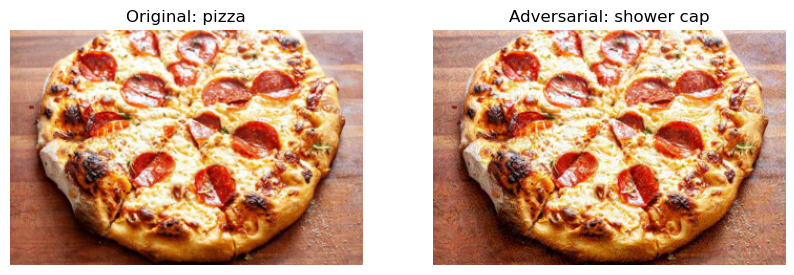

In [88]:
# load the ImageNet class names
with open("/Users/lennox/Documents/machineLearning/data/imagenet_classes.txt") as f:
    class_names = [line.strip() for line in f.readlines()]

# load the pretrained ResNet34 model
model = models.resnet34(weights='IMAGENET1K_V1')
model.eval()

# load image and preprocess it
image = Image.open("/Users/lennox/Documents/machineLearning/data/pizza.jpg")
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])
image_tensor = transform(image).unsqueeze(0)
# predict the class for the original image
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1) 

# get the class name for the predicted index
original_class_name = class_names[predicted_class.item()]
print(f"Original predicted class: {original_class_name}")

# define the FGSM attack
from torchattacks import FGSM
# eps controls the magnitude of the perturbation
fgsm = FGSM(model, eps=0.03) 

# generate adversarial example
adv_image_tensor = fgsm(image_tensor, predicted_class)

# test the adversarial example
with torch.no_grad():
    adv_output = model(adv_image_tensor)
    _, adv_predicted_class = torch.max(adv_output, 1)

# get the class name for the adversarial prediction
adversarial_class_name = class_names[adv_predicted_class.item()]

print(f"Adversarial predicted class: {adversarial_class_name}")

# convert tensors back to images for visualization
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)  
    tensor = tensor.permute(1, 2, 0) 
    tensor = tensor * 255  
    tensor = tensor.byte()  
    image = Image.fromarray(tensor.numpy())
    return image

# convert tensors to images for display
original_image_display = tensor_to_image(image_tensor)
adv_image_display = tensor_to_image(adv_image_tensor)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image_display)
plt.title(f"Original: {original_class_name}")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(adv_image_display)
plt.title(f"Adversarial: {adversarial_class_name}")
plt.axis('off')
plt.show()

### 3.1.2 Projected Gradient Descent (PGD)
PGD improves upon FGSM by adding iterative steps and projecting the perturbed image back into the valid epsilon-ball. This method is slower but more effective.


Original predicted class: notebook
Adversarial predicted class: pencil sharpener


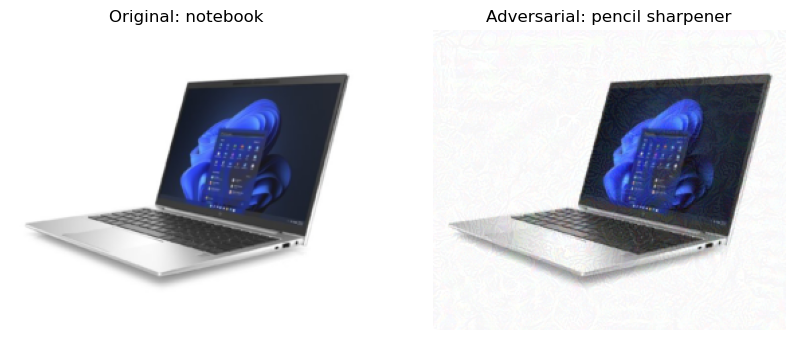

In [266]:
# load the ImageNet class names
with open("/Users/lennox/Documents/machineLearning/data/imagenet_classes.txt") as f:
    class_names = [line.strip() for line in f.readlines()]

# load the pretrained ResNet34 model
model = models.resnet34(weights='IMAGENET1K_V1')
model.eval()  # set the model to evaluation mode

# load an image and preprocess it
image = Image.open("/Users/lennox/Documents/machineLearning/data/laptop.jpg")

# preprocess the image: resize it and convert it to a tensor
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

# apply the preprocessing and add a batch dimension
image_tensor = transform(image).unsqueeze(0)

# predict the class for the original image
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

# get the class name for the predicted index
original_class_name = class_names[predicted_class.item()]

print(f"Original predicted class: {original_class_name}")

# import and define the PGD attack
from torchattacks import PGD
# eps controls the max perturbation, alpha controls step size
pgd = PGD(model, eps=0.03, alpha=2/255, steps=40)  

# generate the adversarial example using PGD
adv_image_tensor = pgd(image_tensor, predicted_class)

# test the adversarial example
with torch.no_grad():
    adv_output = model(adv_image_tensor)
    _, adv_predicted_class = torch.max(adv_output, 1)

# get the class name for the adversarial prediction
adversarial_class_name = class_names[adv_predicted_class.item()]

print(f"Adversarial predicted class: {adversarial_class_name}")

# function to convert tensors back to images for visualization
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0) 
    # reorder to (H, W, C)
    tensor = tensor.permute(1, 2, 0) 
    tensor = tensor * 255  # rescale to [0, 255]
    # convert to uint8
    # convert to uint8 refers to converting the image data to 8-bit unsigned integers (0-255), which is the standard format for pixel values in images
    tensor = tensor.byte()  
    # convert to PIL Image
    # converting to a PIL Image allows the tensor to be transformed into a format suitable for display, manipulation, or saving in image-related tasks
    image = Image.fromarray(tensor.numpy())  
    return image

# convert tensors to images so we can display
# removing the batch dimension converts a tensor from [batch_size, channels, height, width] to [channels, height, width], making it easier to work with individual images
original_image_display = tensor_to_image(image_tensor)
adv_image_display = tensor_to_image(adv_image_tensor)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image_display)
plt.title(f"Original: {original_class_name}")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(adv_image_display)
plt.title(f"Adversarial: {adversarial_class_name}")
plt.axis('off')
plt.show()


### 3.1.3 Carlini & Wagner (C&W) Attack
The C&W attack minimizes the perturbation size while enforcing a false classification with high confidence.


Original predicted class: goldfish
C&W Adversarial predicted class: tench


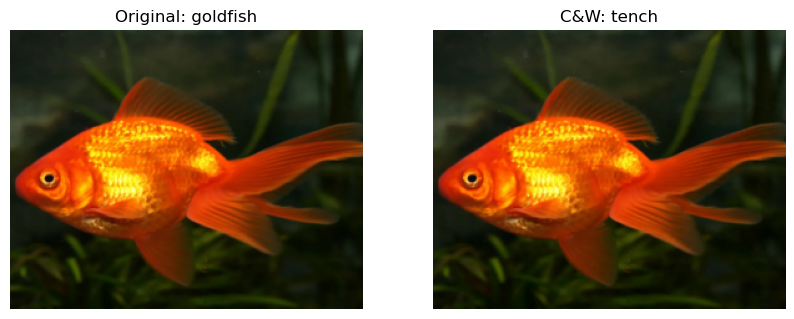

In [291]:
# load the ImageNet class names
with open("/Users/lennox/Documents/machineLearning/data/imagenet_classes.txt") as f:
    class_names = [line.strip() for line in f.readlines()]

# load the pretrained ResNet34 model
model = models.resnet34(weights='IMAGENET1K_V1')
model.eval()

image_path = "/Users/lennox/Documents/machineLearning/data/Goldfish.JPEG"
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

image_tensor = transform(image).unsqueeze(0) 

with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1) 

original_class_name = class_names[predicted_class.item()]
print(f"Original predicted class: {original_class_name}")

# define the Carlini & Wagner attack
from torchattacks import CW
# adjust parameters based on desired attack strength
cw = CW(model, c=1e-1, kappa=20, steps=2000, lr=0.005)  

# generate adversarial example using C&W
adv_image_tensor_cw = cw(image_tensor, predicted_class)

# test the adversarial example from C&W
with torch.no_grad():
    adv_output_cw = model(adv_image_tensor_cw)
    _, adv_predicted_class_cw = torch.max(adv_output_cw, 1)

# Get the class name for the adversarial prediction from C&W
adversarial_class_name_cw = class_names[adv_predicted_class_cw.item()]

print(f"C&W Adversarial predicted class: {adversarial_class_name_cw}")

# convert tensors back to images for visualization
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)  
    tensor = tensor.permute(1, 2, 0) 
    tensor = tensor * 255  
    tensor = tensor.byte()  
    image = Image.fromarray(tensor.numpy()) 
    return image

# convert tensors to images for display
original_image_display = tensor_to_image(image_tensor)
adv_image_display_cw = tensor_to_image(adv_image_tensor_cw)



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image_display)
plt.title(f"Original: {original_class_name}")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(adv_image_display_cw)
plt.title(f"C&W: {adversarial_class_name_cw}")
plt.axis('off')
plt.show()


### **3.2 Gradient-Approximating Attacks**
Gradient-approximating attacks rely on approximating the model gradient without direct access to it. These are considered grey-box attacks, where the attacker does not have full access to the model's internal structure.

---

### 3.2.1 DeepFool Attack
DeepFool finds the minimal perturbation required to change the classification of the input. It uses a first-order approximation to compute the adversarial example.


Original predicted class: ambulance
DeepFool Adversarial predicted class: police van


(-0.5, 297.5, 223.5, -0.5)

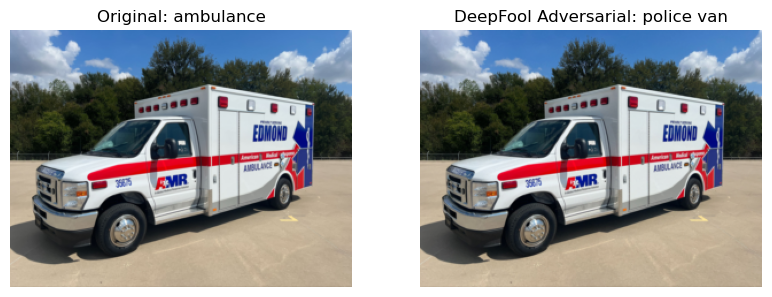

In [329]:
# load the ImageNet class names
with open("/Users/lennox/Documents/machineLearning/data/imagenet_classes.txt") as f:
    class_names = [line.strip() for line in f.readlines()]

# load the pre-trained ResNet34 model
model = models.resnet34(weights='IMAGENET1K_V1')
model.eval()  # set the model to evaluation mode

# load an image and preprocess it
image_path = "/Users/lennox/Documents/machineLearning/data/ambulance.jpeg"
image = Image.open(image_path)

# preprocess the image: resize it and convert it to a tensor
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

# apply the preprocessing and add a batch dimension
image_tensor = transform(image).unsqueeze(0)

# predict the class for the original image
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1) 

# get the class name for the predicted index
original_class_name = class_names[predicted_class.item()]
print(f"Original predicted class: {original_class_name}")

# define the DeepFool attack with more steps and increased overshoot
deepfool = DeepFool(model, steps=300, overshoot=0.02) 

# pass the predicted class as the target label to the DeepFool attack
adv_image_tensor_deepfool = deepfool(image_tensor, predicted_class)

# test the adversarial example from DeepFool
with torch.no_grad():
    adv_output_deepfool = model(adv_image_tensor_deepfool)
    _, adv_predicted_class_deepfool = torch.max(adv_output_deepfool, 1)

# get the class name for the adversarial prediction from DeepFool
adversarial_class_name_deepfool = class_names[adv_predicted_class_deepfool.item()]
print(f"DeepFool Adversarial predicted class: {adversarial_class_name_deepfool}")

# visualize the perturbation
perturbation = (adv_image_tensor_deepfool - image_tensor).abs()

# function to convert tensors back to images for visualization
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)
    tensor = tensor.permute(1, 2, 0)
    tensor = tensor * 255 
    # convert to uint8
    tensor = tensor.byte()  
    # convert to PIL Image
    image = Image.fromarray(tensor.numpy()) 
    return image

# convert tensors to images for display
original_image_display = tensor_to_image(image_tensor)
adv_image_display_deepfool = tensor_to_image(adv_image_tensor_deepfool)
perturbation_image = tensor_to_image(perturbation)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_image_display)
plt.title(f"Original: {original_class_name}")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(adv_image_display_deepfool)
plt.title(f"DeepFool Adversarial: {adversarial_class_name_deepfool}")
plt.axis('off')


### 3.2.2 Few-Pixel Attack
The Few-Pixel attack is a gradient-approximating attack that perturbs only a few pixels to cause misclassification.


Predicted class for few-pixel adversarial example: notebook


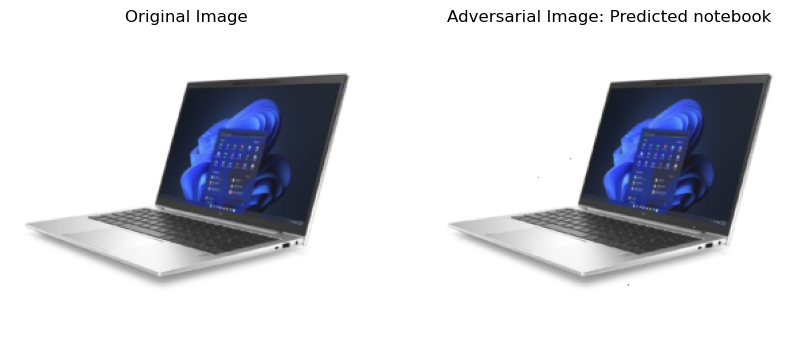

In [260]:
# load the ImageNet class names from the text file
with open("/Users/lennox/Documents/machineLearning/data/imagenet_classes.txt") as f:
    class_names = [line.strip() for line in f.readlines()]

# function to convert a tensor back to an image for visualization
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0) 
    # change dimensions from CxHxW to HxWxC
    tensor = tensor.permute(1, 2, 0)  
    tensor = tensor * 255 
    # convert to uint8
    tensor = tensor.byte()
    return Image.fromarray(tensor.numpy())

# custom few-pixel attack using differential evolution
def few_pixel_attack(image_tensor, model, pixels=5):
    def perturbation_fn(pixels):
        perturbed_image = image_tensor.clone()
        for i in range(0, len(pixels), 3):
            x, y, value = int(pixels[i]), int(pixels[i+1]), pixels[i+2]
            perturbed_image[0, :, x, y] = value
        return perturbed_image

    # fitness function to evaluate the perturbation
    def fitness(pixels):
        perturbed_image = perturbation_fn(pixels)
        output = model(perturbed_image)
        _, predicted = torch.max(output, 1)
        return predicted.item()

    # set the bounds for pixel positions and values
    bounds = [(0, 224), (0, 224), (0, 1)] * pixels
    result = differential_evolution(fitness, bounds, maxiter=100)
    
    return perturbation_fn(result.x)

# test the few-pixel attack
adv_image_tensor_few_pixel = few_pixel_attack(image_tensor, model)

# classify the adversarial image
output = model(adv_image_tensor_few_pixel)
_, adv_pred_few_pixel = torch.max(output, 1)

# get the class name for the predicted index
predicted_class_name = class_names[adv_pred_few_pixel.item()]

print(f"Predicted class for few-pixel adversarial example: {predicted_class_name}")

# convert tensors to images for display
original_image_display = tensor_to_image(image_tensor)
adv_image_display_few_pixel = tensor_to_image(adv_image_tensor_few_pixel)

# display the original and adversarial images
plt.figure(figsize=(10, 5))

# show the original image
plt.subplot(1, 2, 1)
plt.imshow(original_image_display)
plt.title("Original Image")
plt.axis('off')

# show the adversarial image with few-pixel attack
plt.subplot(1, 2, 2)
plt.imshow(adv_image_display_few_pixel)
plt.title(f"Adversarial Image: Predicted {predicted_class_name}")
plt.axis('off')
plt.show()


### 3.3.1 Adversarial Patch Attack (Targeted)
In this section, we will load one of the adversarial patches that was created through the [patchCreation.ipynb](https://github.com/lennox55555/AI-Alignment-Technical-Research/blob/main/Adversarial%20AI%20Saftey/CreatingAPatch.ipynb) and test it against a pre-trained model.


Patch placed at: (x: 112, y: 148), Patch size: 67x67
Predicted class for the image with adversarial patch: hamster


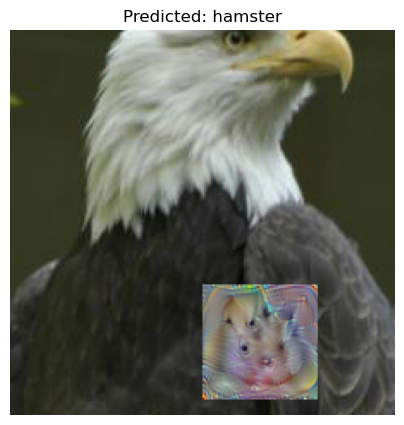

In [247]:
# load the ImageNet class names from the text file into a list
with open("/Users/lennox/Documents/machineLearning/data/imagenet_classes.txt") as f:
    class_names = [line.strip() for line in f.readlines()]

# load a pretrained ResNet34 model with ImageNet weights for classification tasks
model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
model.eval()  # set the model to evaluation mode since we are not training it

# load the base image where the adversarial patch will be applied
base_image = Image.open("/Users/lennox/Documents/machineLearning/data/TinyImageNet/n01614925/n01614925_10041.JPEG")

# load the adversarial patch that we made in patchCreation file
patch = Image.open("./hamsterPatch.png")

# ensure both the base image and patch are in RGB mode
if base_image.mode != 'RGB':
    base_image = base_image.convert('RGB')

if patch.mode != 'RGB':
    patch = patch.convert('RGB')

# define a preprocessing pipeline for the base image and patch: resize to 224x224 and convert to tensor
preprocess = transforms.Compose([
    transforms.Resize(224),  # resize both images to 224x224 to match ResNet input size
    transforms.ToTensor(),  # convert the images to PyTorch tensors
])

# randomly resize the patch to a smaller size between 50x50 and 100x100 pixels for variation in the patch size
patch_size = random.randint(64, 86)
patch = patch.resize((patch_size, patch_size))

# determine the random position where the patch will be placed on the base image
base_image_size = base_image.size  
max_x = base_image_size[0] - patch_size  
max_y = base_image_size[1] - patch_size  

# calculate random coordinates for the top-left corner of the patch
x = random.randint(0, max_x)
y = random.randint(0, max_y)

# paste the patch onto the base image at the randomly chosen position
base_image_with_patch = base_image.copy()  
base_image_with_patch.paste(patch, (x, y)) 

# convert the modified image (with the patch) to a tensor for model input
base_image_tensor = preprocess(base_image_with_patch).unsqueeze(0) 

# classify the modified image using the pre-trained ResNet34 model
with torch.no_grad():  
    output = model(base_image_tensor)
    _, predicted = torch.max(output, 1)  

# map the predicted index to the corresponding class name from the ImageNet labels
predicted_class_name = class_names[predicted.item()]

# display information about the patch placement and the models prediction
print(f"Patch placed at: (x: {x}, y: {y}), Patch size: {patch_size}x{patch_size}")
print(f"Predicted class for the image with adversarial patch: {predicted_class_name}")

plt.figure(figsize=(5, 5))
plt.imshow(base_image_with_patch)
plt.title(f"Predicted: {predicted_class_name}") 
plt.axis('off')  
plt.show()  


### Metrics

---

### Accuracy
The accuracy is defined as: Accuracy = 1 - (False Classifications / Total Classifications)

This metric is commonly used to evaluate the performance of models on a test dataset.


In [305]:
# example on how to calculate accuracy for classification model

# dummy data
y_true = np.array([0, 1, 0, 1, 1, 0, 1, 0])
y_pred = np.array([0, 0, 0, 1, 1, 0, 1, 1])

# calculate accuracy given formula above
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 75.00%


### Failure Rate
The failure rate λ is defined as: λ = False Classifications / Total Time

This metric is important in safety-critical systems to estimate the number of failures per second.


In [307]:
# example on how to calculate failure rate for a classification model
false_classifications = 2
total_time_seconds = 120 

failure_rate = false_classifications / total_time
print(f"Failure Rate: {failure_rate:.6f} failures/second")


Failure Rate: 0.016667 failures/second


### Robustness
Robustness measures how resistant a model is to induced failures. Two important metrics are:

1. Percent Change in Accuracy: % ΔACC = ((Accuracy - Control Accuracy) / Control Accuracy) * 100

2. Relative Change in Failure Rate: Δλ = (Control Failure Rate - Failure Rate) / Control Failure Rate


In [309]:
# example on how to calculate Percent Change in Accuracy and Relative Change in Failure Rate
control_model_accuracy = 0.95  
after_attack_accuracy = 0.90 

percent_change_acc = (after_attack_accuracy - control_model_accuracy) / control_model_accuracy * 100
print(f"Percent Change in Accuracy: {percent_change_acc:.2f}%")

control_model_failure_rate = 0.00001
after_attack_failure_rate = 0.00002  

relative_change_lambda = (control_model_failure_rate - after_attack_failure_rate) / control_model_failure_rate
print(f"Relative Change in Failure Rate: {relative_change_lambda:.2f}")


Percent Change in Accuracy: -5.26%
Relative Change in Failure Rate: -1.00
